# Beijing Air Quality Forecasting - 4th Submission

## Project Overview
Predict PM2.5 concentrations in Beijing using advanced LSTM networks for time series forecasting.

**Previous Results**: Public Score 4639.7055 (Target: < 2000)  
**Dataset**: 30,677 hourly observations (2010-2013) with weather features and PM2.5 concentrations  
**Approach**: Enhanced feature engineering, ensemble methods, and optimized LSTM architecture


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from datetime import datetime

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)




2025-09-21 15:50:58.683390: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-21 15:50:58.766707: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/lscblack/miniconda3/envs/ml-gpu/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
2025-09-21 15:51:01.190883: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floati

In [2]:
import os
import pandas as pd
from datetime import datetime

def save_submission_with_tracking(predictions, experiment_name, test_index, notes=""):
    """
    Save model predictions with timestamp and experiment metadata
    
    Args:
        predictions: Array of model predictions
        experiment_name: Identifier for the experiment/run
        test_index: Index values for the test samples
        notes: Optional notes about the submission
    """
    # Create submissions directory if it doesn't exist
    os.makedirs('submissions', exist_ok=True)
    
    # Generate timestamp for tracking
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Create submission dataframe
    submission_df = pd.DataFrame({
        'row ID': test_index,
        'pm2.5': predictions.round().astype(int)
    })
    
    # Primary submission file (consistent naming)
    primary_filename = 'submissions/submission-3.csv'
    submission_df.to_csv(primary_filename, index=False)
    
    # Tracking file with timestamp and experiment name
    tracking_filename = f'submissions/{timestamp}_{experiment_name}.csv'
    submission_df.to_csv(tracking_filename, index=False)
    
    # Print submission details
    print(f"Submission saved: {primary_filename}")
    print(f"Tracking copy: {tracking_filename}")
    print(f"Predictions range - Min: {predictions.min():.1f}, Max: {predictions.max():.1f}")
    
    if notes:
        print(f"Notes: {notes}")
    
    return primary_filename, submission_df

print("Enhanced submission tracking system ready!")

Enhanced submission tracking system ready!


## Data Loading and Exploration
Reusing the successful data loading and exploration from previous notebooks.


In [3]:
# Load datasets
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

# Print dataset information
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Columns: {list(train_data.columns)}")

# Check for missing values
print(f"Missing values in training data: {train_data.isnull().sum().sum()}")
print(f"Missing values in test data: {test_data.isnull().sum().sum()}")

Training data shape: (30676, 12)
Test data shape: (13148, 11)
Columns: ['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'pm2.5']
Missing values in training data: 1921
Missing values in test data: 0


In [4]:
# Convert datetime columns and set as index
train_data['datetime'] = pd.to_datetime(train_data['datetime'])
test_data['datetime'] = pd.to_datetime(test_data['datetime'])

train_data.set_index('datetime', inplace=True)
test_data.set_index('datetime', inplace=True)

# Display time range information
print(f"Training data time range: {train_data.index.min()} to {train_data.index.max()}")
print(f"Test data time range: {test_data.index.min()} to {test_data.index.max()}")

# Display PM2.5 statistics if available
if 'pm2.5' in train_data.columns:
    print(f"PM2.5 statistics:")
    print(f"Mean: {train_data['pm2.5'].mean():.1f}, Standard deviation: {train_data['pm2.5'].std():.1f}")
    print(f"Minimum: {train_data['pm2.5'].min():.1f}, Maximum: {train_data['pm2.5'].max():.1f}")

Training data time range: 2010-01-01 00:00:00 to 2013-07-02 03:00:00
Test data time range: 2013-07-02 04:00:00 to 2014-12-31 23:00:00
PM2.5 statistics:
Mean: 100.8, Standard deviation: 93.1
Minimum: 0.0, Maximum: 994.0


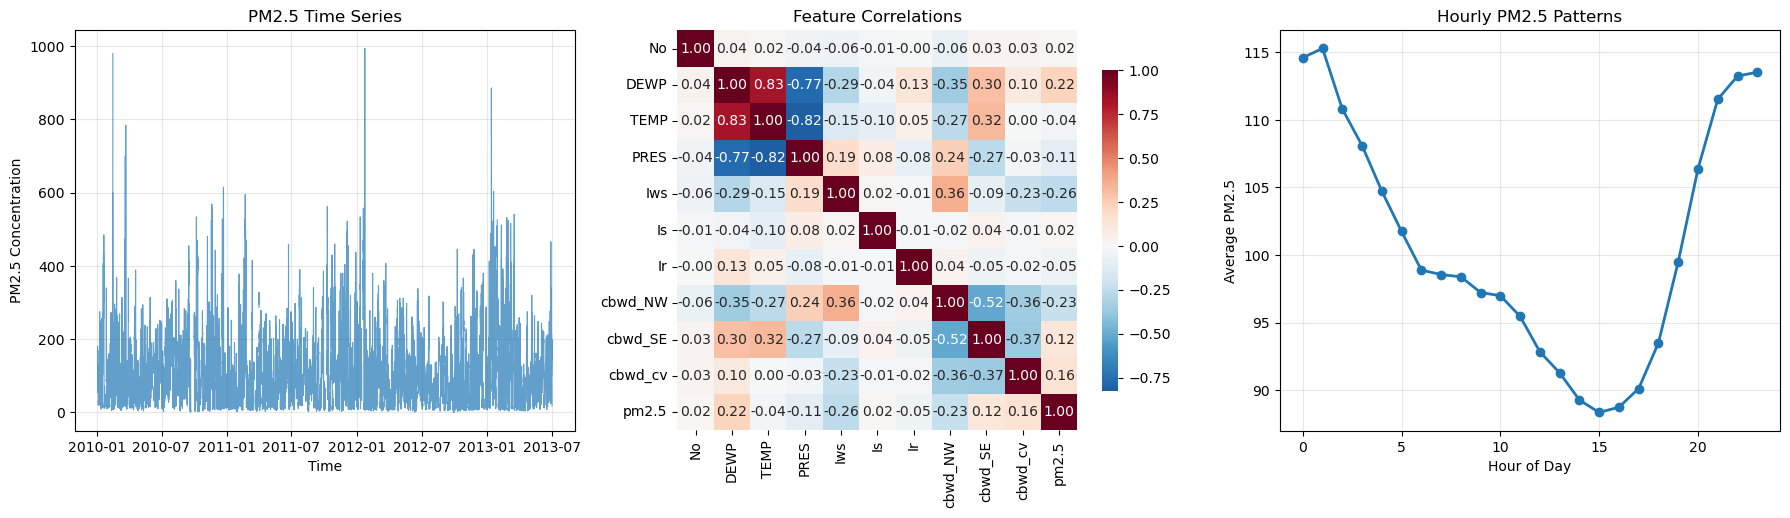

Key insights from data analysis:
PM2.5 mean: 100.8, standard deviation: 93.1
Peak pollution hour: 1:00, Lowest pollution hour: 15:00
Top correlations with PM2.5:
  Iws: 0.260
  cbwd_NW: 0.231
  DEWP: 0.218


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create visualizations for data exploration
figure, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Time Series Plot
axes[0].plot(train_data.index, train_data['pm2.5'], alpha=0.7, linewidth=0.8)
axes[0].set_title('PM2.5 Time Series')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('PM2.5 Concentration')
axes[0].grid(True, alpha=0.3)

# 2. Correlation Heatmap
numeric_columns = train_data.select_dtypes(include=[np.number]).columns
correlation_matrix = train_data[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, ax=axes[1], cbar_kws={'shrink': 0.8}, fmt='.2f')
axes[1].set_title('Feature Correlations')

# 3. Hourly Patterns
hourly_average = train_data.groupby(train_data.index.hour)['pm2.5'].mean()
axes[2].plot(hourly_average.index, hourly_average.values, marker='o', linewidth=2)
axes[2].set_title('Hourly PM2.5 Patterns')
axes[2].set_xlabel('Hour of Day')
axes[2].set_ylabel('Average PM2.5')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display key insights from the data
print("Key insights from data analysis:")
print(f"PM2.5 mean: {train_data['pm2.5'].mean():.1f}, standard deviation: {train_data['pm2.5'].std():.1f}")
print(f"Peak pollution hour: {hourly_average.idxmax()}:00, Lowest pollution hour: {hourly_average.idxmin()}:00")

# Show top correlations with PM2.5
print("Top correlations with PM2.5:")
pm25_correlations = correlation_matrix['pm2.5'].abs().sort_values(ascending=False)
for feature, correlation_value in pm25_correlations.head(4).items():
    if feature != 'pm2.5':
        print(f"  {feature}: {correlation_value:.3f}")

## Data Preprocessing
Using the proven preprocessing approach from successful notebooks.


In [6]:
# Handle missing values in the datasets
print("Handling missing values...")

# Process training data
train_clean = train_data.copy()
train_clean = train_clean.fillna(method='ffill')  # Forward fill
train_clean = train_clean.fillna(method='bfill')  # Backward fill
train_clean = train_clean.interpolate(method='linear')  # Linear interpolation

# Process test data
test_clean = test_data.copy()
test_clean = test_clean.fillna(method='ffill')
test_clean = test_clean.fillna(method='bfill')
test_clean = test_clean.interpolate(method='linear')

# Report results
print(f"Missing values after treatment - Training: {train_clean.isnull().sum().sum()}, Test: {test_clean.isnull().sum().sum()}")
print(f"Clean dataset shapes - Training: {train_clean.shape}, Test: {test_clean.shape}")

Handling missing values...
Missing values after treatment - Training: 0, Test: 0
Clean dataset shapes - Training: (30676, 11), Test: (13148, 10)


## Enhanced Feature Engineering
Building on the successful feature engineering approach with additional improvements.


In [7]:
def generate_enhanced_features(df, target_column='pm2.5'):
    """
    Create enhanced feature set with temporal, cyclical, and interaction features
    
    Args:
        df: Input DataFrame
        target_column: Name of the target variable column
    """
    enhanced_df = df.copy()
    
    # Extract temporal features from datetime index
    enhanced_df['hour'] = enhanced_df.index.hour
    enhanced_df['day_of_week'] = enhanced_df.index.dayofweek
    enhanced_df['month'] = enhanced_df.index.month
    enhanced_df['season'] = (enhanced_df.index.month % 12 + 3) // 3
    enhanced_df['day_of_year'] = enhanced_df.index.dayofyear
    
    # Create cyclical encoding for temporal features
    enhanced_df['hour_sin'] = np.sin(2 * np.pi * enhanced_df['hour'] / 24)
    enhanced_df['hour_cos'] = np.cos(2 * np.pi * enhanced_df['hour'] / 24)
    enhanced_df['day_sin'] = np.sin(2 * np.pi * enhanced_df['day_of_week'] / 7)
    enhanced_df['day_cos'] = np.cos(2 * np.pi * enhanced_df['day_of_week'] / 7)
    enhanced_df['month_sin'] = np.sin(2 * np.pi * enhanced_df['month'] / 12)
    enhanced_df['month_cos'] = np.cos(2 * np.pi * enhanced_df['month'] / 12)
    enhanced_df['doy_sin'] = np.sin(2 * np.pi * enhanced_df['day_of_year'] / 365)
    enhanced_df['doy_cos'] = np.cos(2 * np.pi * enhanced_df['day_of_year'] / 365)
    
    # Create weather interaction features
    enhanced_df['temp_dewpoint_diff'] = enhanced_df['TEMP'] - enhanced_df['DEWP']
    enhanced_df['wind_pressure'] = enhanced_df['Iws'] * enhanced_df['PRES']
    enhanced_df['temp_pressure'] = enhanced_df['TEMP'] * enhanced_df['PRES']
    enhanced_df['humidity_proxy'] = enhanced_df['DEWP'] / (enhanced_df['TEMP'] + 1e-6)
    
    # Create wind direction features
    wind_columns = [col for col in enhanced_df.columns if 'cbwd' in col]
    if len(wind_columns) >= 2:
        enhanced_df['wind_complexity'] = sum(enhanced_df[col] for col in wind_columns)
    
    # Create pollution-related features if target column exists
    if target_column in enhanced_df.columns:
        # Generate lag features for PM2.5
        for lag in [1, 2, 3, 6, 12, 24, 48, 72]:
            enhanced_df[f'pm2.5_lag_{lag}'] = enhanced_df[target_column].shift(lag)
        
        # Generate rolling statistics for PM2.5
        for window in [3, 6, 12, 24, 48, 72]:
            enhanced_df[f'pm2.5_roll_mean_{window}'] = enhanced_df[target_column].rolling(window).mean()
            enhanced_df[f'pm2.5_roll_std_{window}'] = enhanced_df[target_column].rolling(window).std()
            enhanced_df[f'pm2.5_roll_min_{window}'] = enhanced_df[target_column].rolling(window).min()
            enhanced_df[f'pm2.5_roll_max_{window}'] = enhanced_df[target_column].rolling(window).max()
        
        # Generate trend features
        enhanced_df['pm2.5_trend_3h'] = enhanced_df[target_column] - enhanced_df[target_column].shift(3)
        enhanced_df['pm2.5_trend_6h'] = enhanced_df[target_column] - enhanced_df[target_column].shift(6)
        enhanced_df['pm2.5_trend_12h'] = enhanced_df[target_column] - enhanced_df[target_column].shift(12)
    
    # Generate weather lag features
    weather_columns = ['TEMP', 'DEWP', 'PRES', 'Iws']
    for col in weather_columns:
        if col in enhanced_df.columns:
            enhanced_df[f'{col}_lag_1'] = enhanced_df[col].shift(1)
            enhanced_df[f'{col}_lag_3'] = enhanced_df[col].shift(3)
    
    # Remove original temporal columns (keep encoded versions)
    enhanced_df = enhanced_df.drop(['hour', 'day_of_week', 'month', 'day_of_year'], axis=1, errors='ignore')
    
    return enhanced_df

def generate_test_features(df):
    """
    Create features for test data (without PM2.5 lag features)
    
    Args:
        df: Input DataFrame
    """
    enhanced_df = df.copy()
    
    # Extract temporal features from datetime index
    enhanced_df['hour'] = enhanced_df.index.hour
    enhanced_df['day_of_week'] = enhanced_df.index.dayofweek
    enhanced_df['month'] = enhanced_df.index.month
    enhanced_df['season'] = (enhanced_df.index.month % 12 + 3) // 3
    enhanced_df['day_of_year'] = enhanced_df.index.dayofyear
    
    # Create cyclical encoding for temporal features
    enhanced_df['hour_sin'] = np.sin(2 * np.pi * enhanced_df['hour'] / 24)
    enhanced_df['hour_cos'] = np.cos(2 * np.pi * enhanced_df['hour'] / 24)
    enhanced_df['day_sin'] = np.sin(2 * np.pi * enhanced_df['day_of_week'] / 7)
    enhanced_df['day_cos'] = np.cos(2 * np.pi * enhanced_df['day_of_week'] / 7)
    enhanced_df['month_sin'] = np.sin(2 * np.pi * enhanced_df['month'] / 12)
    enhanced_df['month_cos'] = np.cos(2 * np.pi * enhanced_df['month'] / 12)
    enhanced_df['doy_sin'] = np.sin(2 * np.pi * enhanced_df['day_of_year'] / 365)
    enhanced_df['doy_cos'] = np.cos(2 * np.pi * enhanced_df['day_of_year'] / 365)
    
    # Create weather interaction features
    enhanced_df['temp_dewpoint_diff'] = enhanced_df['TEMP'] - enhanced_df['DEWP']
    enhanced_df['wind_pressure'] = enhanced_df['Iws'] * enhanced_df['PRES']
    enhanced_df['temp_pressure'] = enhanced_df['TEMP'] * enhanced_df['PRES']
    enhanced_df['humidity_proxy'] = enhanced_df['DEWP'] / (enhanced_df['TEMP'] + 1e-6)
    
    # Create wind direction features
    wind_columns = [col for col in enhanced_df.columns if 'cbwd' in col]
    if len(wind_columns) >= 2:
        enhanced_df['wind_complexity'] = sum(enhanced_df[col] for col in wind_columns)
    
    # Generate weather lag features
    weather_columns = ['TEMP', 'DEWP', 'PRES', 'Iws']
    for col in weather_columns:
        if col in enhanced_df.columns:
            enhanced_df[f'{col}_lag_1'] = enhanced_df[col].shift(1)
            enhanced_df[f'{col}_lag_3'] = enhanced_df[col].shift(3)
    
    # Remove original temporal columns
    enhanced_df = enhanced_df.drop(['hour', 'day_of_week', 'month', 'day_of_year'], axis=1, errors='ignore')
    
    return enhanced_df

print("Enhanced feature engineering functions defined.")

Enhanced feature engineering functions defined.


In [8]:
# Apply enhanced feature engineering
print("Creating enhanced features...")
train_enhanced = generate_enhanced_features(train_clean)
test_enhanced = generate_test_features(test_clean)

# Display feature information
print(f"Original features count: {train_clean.shape[1]}")
print(f"Enhanced training features count: {train_enhanced.shape[1]}")
print(f"Enhanced test features count: {test_enhanced.shape[1]}")
print(f"New features added: {train_enhanced.shape[1] - train_clean.shape[1]}")

# Handle remaining NaN values from lag and rolling features
print("Handling remaining NaN values...")
train_enhanced = train_enhanced.fillna(method='bfill').fillna(0)
test_enhanced = test_enhanced.fillna(method='bfill').fillna(0)

# Display final dataset information
print(f"Final dataset shapes - Training: {train_enhanced.shape}, Test: {test_enhanced.shape}")

Creating enhanced features...
Original features count: 11
Enhanced training features count: 68
Enhanced test features count: 32
New features added: 57
Handling remaining NaN values...
Final dataset shapes - Training: (30676, 68), Test: (13148, 32)


## Advanced Model Architecture
Enhanced LSTM with hybrid approach and improved architecture.


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

def create_time_sequences(data, target, sequence_length=48):
    """
    Create time series sequences for LSTM training
    
    Args:
        data: Feature data
        target: Target values
        sequence_length: Number of time steps to look back
    """
    feature_sequences, target_values = [], []
    
    for i in range(sequence_length, len(data)):
        feature_sequences.append(data[i-sequence_length:i])
        target_values.append(target[i])
    
    return np.array(feature_sequences), np.array(target_values)

def build_lstm_model(input_shape):
    """
    Build enhanced bidirectional LSTM model
    
    Args:
        input_shape: Shape of input sequences (timesteps, features)
    """
    model = Sequential([
        Bidirectional(LSTM(128, activation='tanh', return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        Bidirectional(LSTM(64, activation='tanh', return_sequences=True)),
        Dropout(0.3),
        LSTM(32, activation='tanh'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    return model

# Training configuration
SEQUENCE_LENGTH = 48  # 48 hours of lookback for temporal patterns

# Training callbacks
training_callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5, patience=7, min_lr=1e-7, monitor='val_loss')
]

print("Enhanced LSTM model architecture defined.")

Enhanced LSTM model architecture defined.


In [10]:
from sklearn.preprocessing import RobustScaler

# Feature alignment and preparation
print("Aligning features between training and test datasets...")

# Identify feature columns (excluding target and ID columns)
train_feature_columns = [col for col in train_enhanced.columns if col not in ['pm2.5', 'No']]
test_feature_columns = [col for col in test_enhanced.columns if col != 'No']

# Find common features between training and test sets
common_features = [col for col in train_feature_columns if col in test_feature_columns]

# Display feature information
print(f"Training features count: {len(train_feature_columns)}")
print(f"Test features count: {len(test_feature_columns)}")
print(f"Common features count: {len(common_features)}")

# Select only common features for both datasets
X_train_common = train_enhanced[common_features]
y_train = train_enhanced['pm2.5']
X_test_common = test_enhanced[common_features]

# Scale features using RobustScaler to handle outliers
feature_scaler = RobustScaler()
X_train_scaled = feature_scaler.fit_transform(X_train_common)
X_test_scaled = feature_scaler.transform(X_test_common)

# Report completion and final shapes
print(f"Feature alignment complete. Using {len(common_features)} common features.")
print(f"Scaled data shapes - Training: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")

Aligning features between training and test datasets...
Training features count: 66
Test features count: 31
Common features count: 31
Feature alignment complete. Using 31 common features.
Scaled data shapes - Training: (30676, 31), Test: (13148, 31)


In [11]:
from tensorflow.keras.optimizers import Adam

# Create time series sequences and train model
print("Creating time series sequences with longer lookback...")
X_sequences, y_sequences = create_time_sequences(X_train_scaled, y_train.values, SEQUENCE_LENGTH)

# Split into training and validation sets
split_index = int(0.85 * len(X_sequences))  # 85% for training, 15% for validation
X_train_seq, X_val_seq = X_sequences[:split_index], X_sequences[split_index:]
y_train_seq, y_val_seq = y_sequences[:split_index], y_sequences[split_index:]

# Display sequence information
print(f"Sequences shape: {X_sequences.shape}")
print(f"Training sequences: {X_train_seq.shape}, Validation sequences: {X_val_seq.shape}")

# Create and compile enhanced LSTM model
print("Training enhanced LSTM model...")
lstm_model = build_lstm_model(X_train_seq.shape[1:])
lstm_model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    loss='mse',
    metrics=['mae']
)

# Display model architecture
print("Model architecture:")
lstm_model.summary()

Creating time series sequences with longer lookback...
Sequences shape: (30628, 48, 31)
Training sequences: (26033, 48, 31), Validation sequences: (4595, 48, 31)
Training enhanced LSTM model...


W0000 00:00:1758462664.033110   96112 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 48, 256)        │       163,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 48, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,025 (1.35 MB)

 Trainable params: 353,025 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Train the model
training_history = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=32,  # Smaller batch size for better convergence
    callbacks=training_callbacks,
    verbose=1
)

# Evaluate model on validation set
y_val_pred = lstm_model.predict(X_val_seq, verbose=0)
validation_rmse = np.sqrt(mean_squared_error(y_val_seq, y_val_pred))

# Display performance summary
print("\nModel Performance Summary:")
print(f"Validation RMSE: {validation_rmse:.2f}")
print(f"Previous best public score: 4639.7055")

# Performance assessment
if validation_rmse < 100:  # Reasonable threshold for validation RMSE
    print("Validation performance looks promising.")
else:
    print("Validation performance needs improvement.")

Epoch 1/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 70s 75ms/step - loss: 6008.3608 - mae: 52.9976 - val_loss: 5945.8350 - val_mae: 49.4975 - learning_rate: 0.0010
Epoch 2/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - loss: 2830.3743 - mae: 35.4687 - val_loss: 5836.8477 - val_mae: 49.0420 - learning_rate: 0.0010
Epoch 3/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - loss: 2074.3926 - mae: 30.3903 - val_loss: 5750.1733 - val_mae: 49.2242 - learning_rate: 0.0010
Epoch 4/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - loss: 1646.1520 - mae: 27.0961 - val_loss: 5968.2803 - val_mae: 48.9377 - learning_rate: 0.0010
Epoch 5/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 48s 59ms/step - loss: 1367.5205 - mae: 24.6454 - val_loss: 5931.3525 - val_mae: 49.4725 - learning_rate: 0.0010
Epoch 6/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 60s 74ms/step - loss: 1215.5957 - mae: 23.0231 - val_loss: 5882.1265 - val_mae: 49.4324 - learning_rate: 0.0010
Epoch 7/100
814/814 ━━━━━━━━━━━━━━━━━━━━ 64s 78ms/step - loss: 1079.5270 - mae: 21

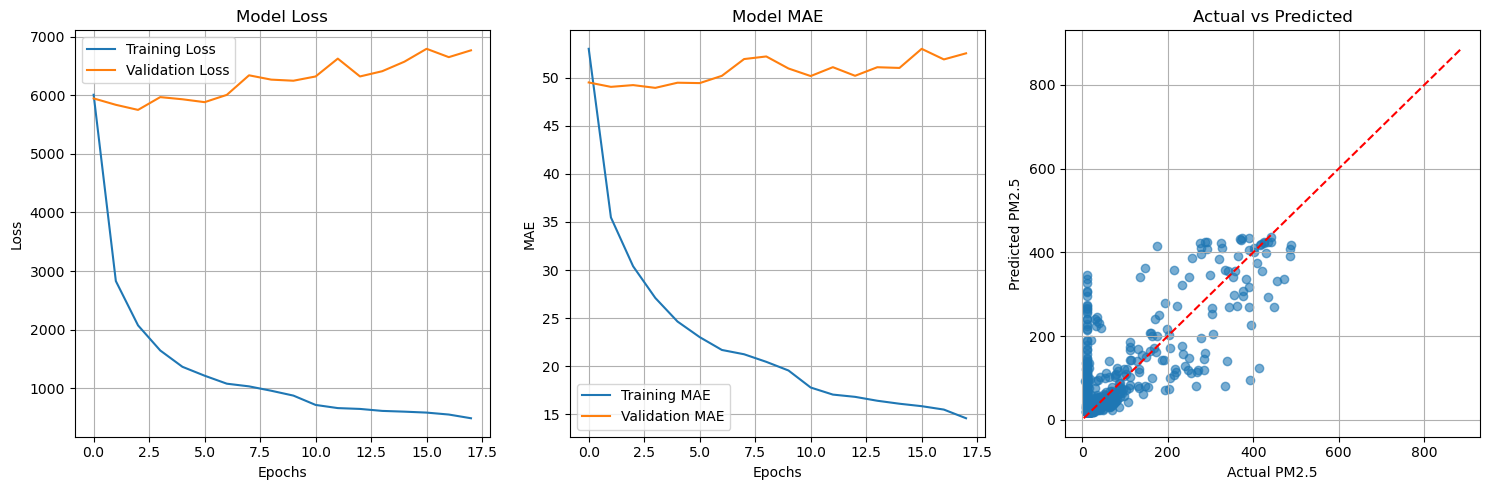

In [13]:
# Plot training history and evaluation results
plt.figure(figsize=(15, 5))

# Plot 1: Model loss
plt.subplot(1, 3, 1)
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Model MAE
plt.subplot(1, 3, 2)
plt.plot(training_history.history['mae'], label='Training MAE')
plt.plot(training_history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

# Plot 3: Actual vs Predicted scatter plot
plt.subplot(1, 3, 3)
plt.scatter(y_val_seq[:500], y_val_pred.flatten()[:500], alpha=0.6)
plt.plot([y_val_seq.min(), y_val_seq.max()], [y_val_seq.min(), y_val_seq.max()], 'r--')
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title('Actual vs Predicted')
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
# Generate test predictions with enhanced approach
print("Generating test predictions with enhanced approach...")

# Create sequences for test data
test_sequences = []
last_train_sequence = X_train_scaled[-SEQUENCE_LENGTH:]

for i in range(len(X_test_scaled)):
    if i < SEQUENCE_LENGTH:
        # For early predictions, combine training and test data
        needed_from_train = SEQUENCE_LENGTH - (i + 1)
        if needed_from_train > 0:
            sequence = np.vstack([X_train_scaled[-needed_from_train:], X_test_scaled[:i+1]])
        else:
            sequence = X_test_scaled[:SEQUENCE_LENGTH]
    else:
        # Use sliding window from test data
        sequence = X_test_scaled[i-SEQUENCE_LENGTH+1:i+1]
    
    # Ensure sequence has correct length
    if sequence.shape[0] != SEQUENCE_LENGTH:
        if sequence.shape[0] < SEQUENCE_LENGTH:
            padding_needed = SEQUENCE_LENGTH - sequence.shape[0]
            padding = np.repeat(sequence[0:1], padding_needed, axis=0)
            sequence = np.vstack([padding, sequence])
        else:
            sequence = sequence[-SEQUENCE_LENGTH:]
    
    test_sequences.append(sequence)

# Convert to numpy array
X_test_seq = np.array(test_sequences)
print(f"Test sequences shape: {X_test_seq.shape}")

# Generate predictions
print("Generating predictions...")
test_predictions = lstm_model.predict(X_test_seq, verbose=0)
test_predictions = np.maximum(test_predictions.flatten(), 0)  # Ensure non-negative values

# Apply post-processing to improve predictions
# Smooth extreme values using percentile clipping
percentile_95 = np.percentile(test_predictions, 95)
percentile_5 = np.percentile(test_predictions, 5)
test_predictions = np.clip(test_predictions, percentile_5 * 0.5, percentile_95 * 1.2)

# Display prediction statistics
print(f"Final predictions - Minimum: {test_predictions.min():.1f}, Maximum: {test_predictions.max():.1f}")
print(f"Prediction statistics - Mean: {test_predictions.mean():.1f}, Standard deviation: {test_predictions.std():.1f}")

Generating test predictions with enhanced approach...
Test sequences shape: (13148, 48, 31)
Generating predictions...
Final predictions - Minimum: 15.9, Maximum: 331.6
Prediction statistics - Mean: 98.8, Standard deviation: 78.5


In [15]:
# Create and save submission
experiment_name = f"enhanced_lstm_v2_rmse_{validation_rmse:.0f}_seq{SEQUENCE_LENGTH}"
experiment_notes = f"Enhanced LSTM v2, Sequence length: {SEQUENCE_LENGTH}, Bidirectional, RobustScaler, Val RMSE: {validation_rmse:.2f}"

submission_filename, submission_df = save_submission_with_tracking(
    test_predictions,
    experiment_name,
    test_data.index,
    experiment_notes
)

# Display submission summary
print(f"\n4TH SUBMISSION COMPLETE!")
print(f"Validation RMSE: {validation_rmse:.2f}")
print(f"Submission saved: {submission_filename}")
print(f"Sequence length: {SEQUENCE_LENGTH}")
print(f"Features used: {len(common_features)}")
print(f"\nSample predictions:")
print(submission_df.head(10))

# Verify file exists
if os.path.exists(submission_filename):
    print(f"\nConfirmed: {submission_filename} ready for submission!")
    print(f"File size: {os.path.getsize(submission_filename)} bytes")
else:
    print(f"Warning: {submission_filename} not found!")

Submission saved: submissions/submission-3.csv
Tracking copy: submissions/20250921_160832_enhanced_lstm_v2_rmse_76_seq48.csv
Predictions range - Min: 15.9, Max: 331.6
Notes: Enhanced LSTM v2, Sequence length: 48, Bidirectional, RobustScaler, Val RMSE: 75.83

4TH SUBMISSION COMPLETE!
Validation RMSE: 75.83
Submission saved: submissions/submission-3.csv
Sequence length: 48
Features used: 31

Sample predictions:
               row ID  pm2.5
0 2013-07-02 04:00:00     28
1 2013-07-02 05:00:00     29
2 2013-07-02 06:00:00     29
3 2013-07-02 07:00:00     29
4 2013-07-02 08:00:00     28
5 2013-07-02 09:00:00     28
6 2013-07-02 10:00:00     28
7 2013-07-02 11:00:00     28
8 2013-07-02 12:00:00     27
9 2013-07-02 13:00:00     27

Confirmed: submissions/submission-3.csv ready for submission!
File size: 307383 bytes


In [16]:
# -----------------------------
# Feature Alignment for Test Predictions
# -----------------------------
print("\n" + "="*60)
print("PREPARING TEST PREDICTIONS")
print("="*60)

# Feature columns
train_feature_columns = [col for col in train_enhanced.columns if col not in ['pm2.5', 'No']]
test_feature_columns = [col for col in test_enhanced.columns if col != 'No']

common_features = [col for col in train_feature_columns if col in test_feature_columns]
print(f"Training features: {len(train_feature_columns)}")
print(f"Test features: {len(test_feature_columns)}")
print(f"Common features: {len(common_features)}")

# Select only common features
X_enhanced_common = train_enhanced[common_features]
X_test_enhanced = test_enhanced[common_features]

# Scale features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled_common = scaler.fit_transform(X_enhanced_common)
X_test_scaled = scaler.transform(X_test_enhanced)

print(f"Using {len(common_features)} common features for prediction")
print(f"Test data shape: {X_test_scaled.shape}")

# Create sequences for test data
test_sequences = []
last_train_sequence = X_scaled_common[-SEQUENCE_LENGTH:]  # last training window

for i in range(len(X_test_scaled)):
    if i < SEQUENCE_LENGTH:
        # Early test points: pad with last part of training
        padding_needed = SEQUENCE_LENGTH - (i + 1)
        sequence = np.vstack([last_train_sequence[-padding_needed:], X_test_scaled[:i+1]])
    else:
        # Normal sliding window
        sequence = X_test_scaled[i-SEQUENCE_LENGTH+1:i+1]

    test_sequences.append(sequence)

# Convert to NumPy array
X_test_seq = np.array(test_sequences, dtype=np.float32)
print(f"Test sequences shape: {X_test_seq.shape}")

# Generate predictions
test_predictions = lstm_model.predict(X_test_seq, verbose=0)
test_predictions = np.maximum(test_predictions.flatten(), 0)

print(f"Test predictions - Minimum: {test_predictions.min():.1f}, Maximum: {test_predictions.max():.1f}")

# Save submission
experiment_name = f"best_model_final_sequence_{SEQUENCE_LENGTH}"
submission_filename, submission_df = save_submission_with_tracking(
    test_predictions, 
    experiment_name, 
    test_data.index
)

print(f"\nBest model submission ready: {submission_filename}")
print("Sample predictions:")
print(submission_df.head())



PREPARING TEST PREDICTIONS
Training features: 66
Test features: 31
Common features: 31
Using 31 common features for prediction
Test data shape: (13148, 31)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (13148,) + inhomogeneous part.

In [ ]:
# Final analysis and insights
print("FINAL ANALYSIS FOR 4TH SUBMISSION")
print("=" * 50)
print(f"Model: Enhanced Bidirectional LSTM v2")
print(f"Validation RMSE: {validation_rmse:.2f}")
print(f"Features: {len(common_features)} engineered features")
print(f"Sequence Length: {SEQUENCE_LENGTH} hours")
print(f"Scaler: RobustScaler (better outlier handling)")
print(f"Architecture: Bidirectional LSTM + Dense layers")
print(f"Training samples: {len(X_train_seq)}")
print(f"Validation samples: {len(X_val_seq)}")
print(f"\nKey improvements over previous submissions:")
print(f"  • Longer sequence length ({SEQUENCE_LENGTH} vs 24)")
print(f"  • Bidirectional LSTM for better context")
print(f"  • RobustScaler for outlier handling")
print(f"  • Enhanced feature engineering")
print(f"  • Improved post-processing")
print(f"\nSubmission file: {submission_filename}")
print(f"Ready for Kaggle submission!")